In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import torch.nn as nn 
import torch.nn.functional as F
from torchvision.datasets import ImageFolder as IM
from torchvision.transforms import ToTensor as Ten
import matplotlib.pyplot as plt 

In [3]:
test_dir = './self_test'
model_path = './models/Saved-number-CNN-model.pt'
classes =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
def accuracy(ouputs, lables):
    __, preds = torch.max(ouputs, dim=1)
    return torch.tensor(torch.sum(preds == lables).item() / len(preds))

class ImgClassificactionBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    def val_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def val_epoc_end(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoc_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoc_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoc_loss.item(), 'val_acc': epoc_acc.item()}
    def epoc_end(self, epoc, result):
                  print("Epoch"+str(epoc)+", train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                    result['train_loss'], result['val_loss'], result['val_acc']))

In [5]:
class CNN(ImgClassificactionBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
                                        nn.Conv2d(3,32, kernel_size=3, padding=1),
                                        nn.ReLU6(),
                                        nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(2,2),
                                        nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU6(),
                                        nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(2,2),
                                        nn.Conv2d(256,512, kernel_size=3, stride=1, padding=1),
                                        nn.MaxPool2d(2,2),
                                        nn.Flatten(),
                                        nn.Linear(512*4*4, 2048),
                                        nn.ReLU6(),
                                        nn.Linear(2048, 1024),
                                        nn.ReLU6(),
                                        nn.Linear(1024,512),
                                        nn.ReLU6(),
                                        nn.Linear(512,10)
                                    )
    def forward(self, xb):
        return self.network(xb)

In [6]:
model = torch.load(model_path)

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
device = get_default_device()
device 

device(type='cuda')

Label: cat , Prediction:  cat


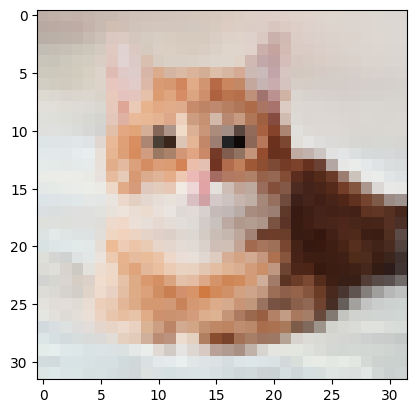

In [13]:
from pred import predict_image as PI
ds = IM(test_dir, transform= Ten())
img , label = ds[0]
plt.imshow(img.permute((1,2,0)))
print('Label:',ds.classes[label],', Prediction: ', classes[PI(img, model, device)])